In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import scipy.stats as stats
from scipy.stats import kstest

In [2]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score
import sklearn.metrics as skm






In [3]:
flights = pd.read_csv('flights_sample5pct.csv')

/Users/phanisingaraju/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Flights columns to drop due to high Nans
drop_cols = ['carrier_delay',
'weather_delay',
'nas_delay',
'security_delay',
'late_aircraft_delay',
'first_dep_time',
'total_add_gtime',
'longest_add_gtime',
'no_name','cancellation_code']
flights = flights.drop(drop_cols, axis =1)

In [5]:
date_split = flights['fl_date'].str.split('-')
date_split[:3]
flights['year'] = [x[0] for x in date_split]
flights['month'] = [x[1] for x in date_split]
flights['day'] = [x[2] for x in date_split]

In [6]:
flights.columns

Index(['Unnamed: 0', 'fl_date', 'mkt_unique_carrier', 'branded_code_share',
       'mkt_carrier', 'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted', 'dup',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'year', 'month', 'day'],
      dtype='object')

In [9]:
flights.mkt_carrier.value_counts()

AA    207135
DL    174009
UA    154896
WN    135581
AS     42674
B6     29983
NK     19050
F9     12767
G4     10100
HA      9281
VX       852
Name: mkt_carrier, dtype: int64

In [10]:
flights_feature = flights.filter(['fl_date','month','day','mkt_carrier','mkt_carrier_fl_num','origin','dest','crs_dep_time','distance','crs_arr_time', 'arr_delay'], axis=1)

In [11]:
flights_feature.head()

,fl_date,month,day,mkt_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,distance,crs_arr_time,arr_delay
0,2018-09-20,09,20,DL,7362,MQT,MSP,731,300,749,-17.0
1,2018-09-20,09,20,DL,7369,APN,PLN,528,69,613,-16.0
2,2018-09-20,09,20,DL,7383,CPR,SLC,1145,320,1309,-13.0
3,2018-09-20,09,20,DL,7406,MQT,DTW,1510,349,1635,-18.0
4,2018-09-20,09,20,DL,7408,PLN,APN,2150,69,2229,73.0


In [13]:
flights_feature.isna().sum()

fl_date                   0
month                     0
day                       0
mkt_carrier               0
mkt_carrier_fl_num        0
origin                    0
dest                      0
crs_dep_time              0
distance                  0
crs_arr_time              0
arr_delay             15508
dtype: int64

In [14]:
flights_feature['month']=flights_feature['month'].astype(str).astype(int)
flights_feature['day']=flights_feature['day'].astype(str).astype(int)
flights_feature['fl_date'] = pd.to_datetime(flights_feature['fl_date'])
flights_feature['day_of_week'] = flights_feature['fl_date'].dt.dayofweek
bins = [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400]
flights_feature['binned_dep'] = np.searchsorted(bins, flights_feature['crs_dep_time'].values)
flights_feature['binned_arr'] = np.searchsorted(bins, flights_feature['crs_arr_time'].values)
bins = [0, 1100, 4100, 10000]
flights_feature['binned_distance'] = np.searchsorted(bins, flights_feature['distance'].values)

In [15]:
flights_feature.dtypes

fl_date               datetime64[ns]
month                          int64
day                            int64
mkt_carrier                   object
mkt_carrier_fl_num             int64
origin                        object
dest                          object
crs_dep_time                   int64
distance                       int64
crs_arr_time                   int64
arr_delay                    float64
day_of_week                    int64
binned_dep                     int64
binned_arr                     int64
binned_distance                int64
dtype: object

In [16]:
from sklearn.preprocessing import LabelEncoder
flights_feature['carrier_encoded']=LabelEncoder().fit_transform(flights_feature.mkt_carrier )
flights_feature['origin_encoded']=LabelEncoder().fit_transform(flights_feature.origin)
flights_feature['dest_encoded']=LabelEncoder().fit_transform(flights_feature.dest)

In [17]:
flights_feature.columns

Index(['fl_date', 'month', 'day', 'mkt_carrier', 'mkt_carrier_fl_num',
       'origin', 'dest', 'crs_dep_time', 'distance', 'crs_arr_time',
       'arr_delay', 'day_of_week', 'binned_dep', 'binned_arr',
       'binned_distance', 'carrier_encoded', 'origin_encoded', 'dest_encoded'],
      dtype='object')

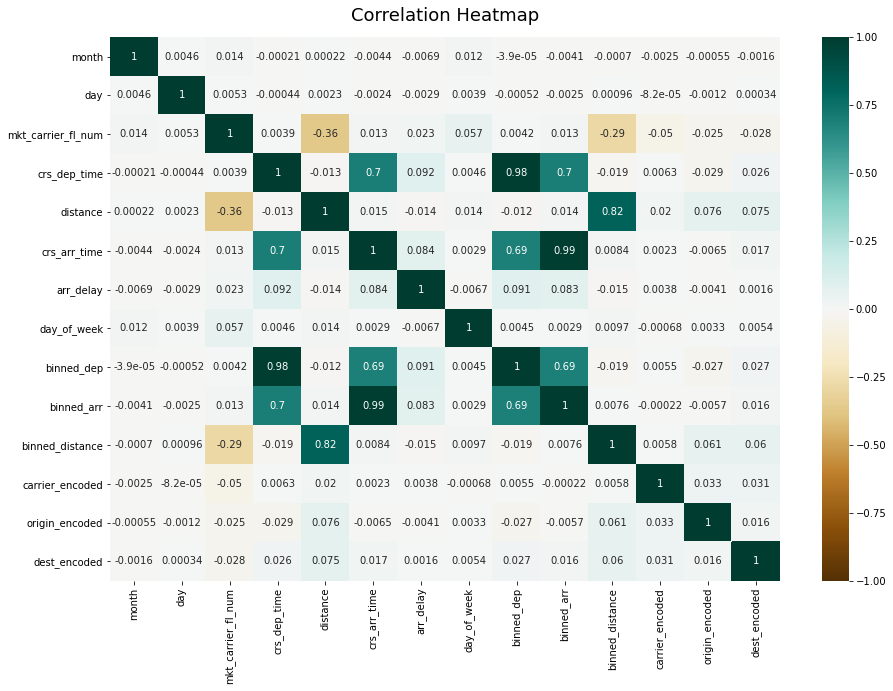

In [18]:
fig, ax = plt.subplots(figsize=(15,10)) 
heatmap = sns.heatmap(flights_feature.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.savefig('arrdelayfeatures.png', dpi=300, bbox_inches='tight')

In [19]:
flights_feature.drop(columns=['fl_date','origin','dest','mkt_carrier','crs_dep_time','crs_arr_time','distance'],inplace=True)

In [20]:
flights_feature.arr_delay.mean()

5.578032068850695

In [21]:
flights_feature.arr_delay.fillna(flights_feature.arr_delay.mean(),inplace=True)



In [22]:
flights_feature.isna().sum()

month                 0
day                   0
mkt_carrier_fl_num    0
arr_delay             0
day_of_week           0
binned_dep            0
binned_arr            0
binned_distance       0
carrier_encoded       0
origin_encoded        0
dest_encoded          0
dtype: int64

In [23]:
F=flights_feature[['mkt_carrier_fl_num','carrier_encoded','origin_encoded','dest_encoded','month','day','day_of_week','binned_dep','binned_arr','binned_distance']].copy()

In [24]:
F.head()

,mkt_carrier_fl_num,carrier_encoded,origin_encoded,dest_encoded,month,day,day_of_week,binned_dep,binned_arr,binned_distance
0,7362,3,239,243,9,20,3,3,3,1
1,7369,3,19,279,9,20,3,2,3,1
2,7383,3,82,332,9,20,3,4,5,1
3,7406,3,239,103,9,20,3,6,6,1
4,7408,3,279,19,9,20,3,8,8,1


In [25]:
X = F.copy()  # Features
y = flights_feature['arr_delay'] # Target variable

In [26]:
X.shape

(796328, 10)

In [27]:
y.shape

(796328,)

In [28]:
X.columns

Index(['mkt_carrier_fl_num', 'carrier_encoded', 'origin_encoded',
       'dest_encoded', 'month', 'day', 'day_of_week', 'binned_dep',
       'binned_arr', 'binned_distance'],
      dtype='object')

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [30]:
print(X_train.shape)
print(X_test.shape)

(557429, 10)
(238899, 10)


In [118]:
xgb1 = xgb.XGBRegressor(n_estimators=10000, max_depth=6)

In [ ]:
xgb_tr=xgb1.fit(X_train,y_train)

In [104]:
print("Accuracy on training set for XGBoost(n=10000,depth=6): {:.3f}".format(xgb_tr.score(X_train, y_train)))

Accuracy on training set for XGBoost(n=10000,depth=6): 0.804


In [105]:
y_pred_xgb=xgb1.predict(X_test)

In [114]:
results = [
('r2', skm.r2_score(y_test,y_pred_xgb) ),
('explained_variance', skm.explained_variance_score(y_test,y_pred_xgb) ),
('Max_Err', skm.max_error(y_test,y_pred_xgb) ),
('Mean_Abs_Err', skm.mean_absolute_error(y_test,y_pred_xgb) ),
('Mean_Sqr_Err', skm.mean_squared_error(y_test,y_pred_xgb) ),
('Median_Abs_Err', skm.median_absolute_error(y_test,y_pred_xgb) ) ]


In [115]:
for score in results:
    print(score)

('r2', -0.21129537697553213)
('explained_variance', -0.21062662711734115)
('Max_Err', 1607.3971111774445)
('Mean_Abs_Err', 28.213433788340343)
('Mean_Sqr_Err', 2982.3939976305837)
('Median_Abs_Err', 17.055166244506836)
